In [10]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt

import json
import pandas as pd
import numpy as np
import scipy.interpolate
import scipy.optimize

from utils import *

Edit this next cell to choose a different country / year report:

In [16]:
# BGR_3_2001.json
# BRA_3_2001.json
# MWI_3_2010.23.json
# ECU_3_2014.json
# ARM_3_2010.json
# NGA_3_2009.83.json
# IDN_1_2014.json quite pointed / triangular
# PHL_3_2009.json
# ZAR_3_2012.4.json
# TZA_3_2011.77.json
# VNM_3_2008.json
# MOZ_3_2008.67.json quite rounded
# UZB_3_2003.json
# KIR_3_2006.json needs 1e-4
# PNG_3_2009.67.json needs False and 1e-5
# PAK_3_2013.5.json
# BGD_3_2010.json not super good need 1e-5
# ARG_2_1991.json needs False currency scales weird

with open("../jsoncache/PAK_3_2013.5.json","r") as f:
    d = json.loads(f.read())
    
print("Sample size".ljust(20),d['sample']['N'])
for k in d['dataset']:
    print(k.ljust(20),d['dataset'][k])

Sample size          17980
timespan             UnDefined
measure              Consumption
iso3c                PAK
source               PAK_N2013X
coverage             National
year                 2013
country              Pakistan
format               Unit record


These next few conversions don't really work. The PPP data field seems wrong.

In [17]:
# Check poverty line conversion
DAYS_PER_MONTH = 30.4167
line_month_ppp_calc = d['inputs']['line_day_ppp'] * DAYS_PER_MONTH
line_month_ppp_given = d['inputs']['line_month_ppp']
myassert("Poverty line (PPP):", line_month_ppp_calc, line_month_ppp_given)

ppp = d['inputs']['ppp']

line_month_lcu_calc = line_month_ppp_calc * ppp
line_month_lcu_given = d['inputs']['line_month_lcu']
myassert("Poverty line (LCU):", line_month_lcu_calc, line_month_lcu_given)

Poverty line (PPP): 	computed =       57.792	given =       57.792	difference = 0.0%
Poverty line (LCU): 	computed =       1468.7	given =       1797.2	difference = 18.278%


In [18]:
# Check data mean
sample_mean_ppp_calc = d['sample']['mean_month_lcu'] / ppp
sample_mean_ppp_given = d['sample']['mean_month_ppp']
myassert("Data mean (PPP):", sample_mean_ppp_calc, sample_mean_ppp_given)

implied_ppp = d['sample']['mean_month_lcu'] / d['sample']['mean_month_ppp']
myassert("Implied PPP:", implied_ppp, ppp)

Data mean (PPP):    	computed =       164.62	given =       134.53	difference = 22.367%
Implied PPP:        	computed =       31.099	given =       25.414	difference = 22.367%


But this one only works if you use the PPP given applied to sample mean in LCU, which is odd.

In [19]:
pop_N = d['sample']['effective_pop_N']
total_wealth_calc = pop_N * sample_mean_ppp_calc
total_wealth_given = d['sample']['effective_pop_wealth']
myassert("Total wealth:", total_wealth_calc, total_wealth_given)

Total wealth:       	computed = 26808308440.0	given = 26808400000.0	difference = 0.0%


Minimum and maximum can't be checked,  but load them anyway in case we use them later.

In [20]:
# Load the min and max in case we use them to fit the Lorenz curve
sample_max_ppp_given = d['sample']['month_max']
sample_min_ppp_given = d['sample']['month_min']

Gini is calculate directly from from $L(p)$, or perhaps unit record data underlying.

In [21]:
# Load the Lorenz curve
L = d['lorenz']['L']
p = d['lorenz']['p']

# We need to add the origin, by definition
p = [0.0] + p
L = [0.0] + L

# We can, if we want, use the sample min and max to add a point to the curve
if True:
    dp = 1 / d['sample']['N']
    dlorenz_at_0 = sample_min_ppp_given/sample_mean_ppp_given
    dlorenz_at_1 = sample_max_ppp_given/sample_mean_ppp_given
    p_second = 0 + dp
    p_penultimate = 1 - dp
    L_second = 0 + dlorenz_at_0 * dp
    L_penultimate = 1 - dlorenz_at_1 * dp
    p = [0.0, p_second] + p[1:-1] + [p_penultimate, 1.0]
    L = [0.0, L_second] + L[1:-1] + [L_penultimate, 1.0]

lorenz = pd.DataFrame({'p': p, 'L': L})

lorenz['dp'] = lorenz.p.shift(-1)[:-1] - lorenz.p[:-1]
lorenz['dL'] = lorenz.L.shift(-1)[:-1] - lorenz.L[:-1]
lorenz['dLdp'] = lorenz.dL / lorenz.dp

# Now, F(y) = inverse of Q(p)
lorenz['y'] = lorenz.dLdp * sample_mean_ppp_given

# Calc and compare Ginis
G_calc = 1 - sum(0.5 * lorenz.dp[:-1] * (lorenz.L.shift(-1)[:-1] + lorenz.L[:-1])) / 0.5
G_given = d['dist']['Gini']
myassert("Gini:",G_calc, G_given)


Gini:               	computed =       0.3067	given =       0.3069	difference = 0.061%


Estimating tail statistics, like headcount poverty, is a little harder. Povcalnet likely uses the underlying unit record data, and the 100 point Lorenz curve is likely too coarse to get a comparable result. So at this step we fit a model of the Lorenz curve using splines.

We use weights to gently encourage the optimization to fit better at the minimum and maximum incomes, and to the first 10% of Lorenz points (to upweight the left tail fit). Unfortunately very large weights tend to produce spurious peaks in the PDF as the algorithm tries to fit the tails, so we sacrifice the tails to avoid this. It's more of a suggestion than a constraint :-)

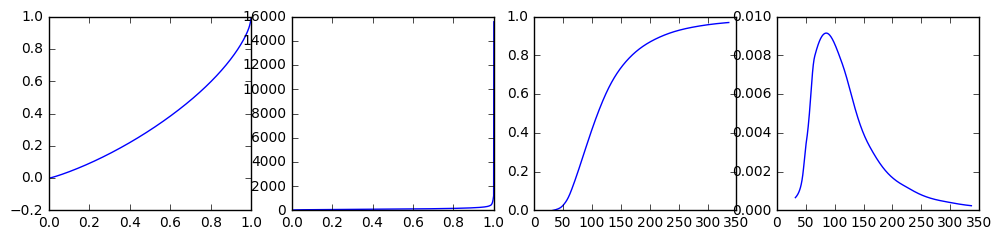

In [22]:
##########################################
plt.rcParams["figure.figsize"] = (12,2.5)
fig, ax = plt.subplots(1, 4)
##########################################

thehead = int(len(lorenz)*0.1)
themiddle = len(lorenz) - thehead - 2 - 2
lorenz.w = ([100, 100] + [10] * thehead) + ([1] * themiddle) + [1, 1]
#lorenz.w = [10]*thehead + [1]*(len(lorenz)-thehead)

lorenz_interp = scipy.interpolate.UnivariateSpline(lorenz.p,lorenz.L,w=lorenz.w,k=5,s=1e-7)
quantile = lambda p: sample_mean_ppp_given * lorenz_interp.derivative()(p)
cdf = inverse(quantile)
pdf = derivative(cdf)

pgrid = np.linspace(0, 1, 1000)
ax[0].plot(pgrid, lorenz_interp(pgrid))
ax[1].plot(pgrid, quantile(pgrid))

ygrid = np.linspace(0, quantile(0.97), 1000)
ax[2].plot(ygrid, cdf(ygrid))
ax[3].plot(ygrid, pdf(ygrid));

Although the sample extrema only say a little about the population extrema, it's interesting to see how they compare with those implied by the spline fit. It is technically disqualifying, but not surprising, if the sample extrema lie outside those from the fit.

If the natural computed maximum is less than the given, we want to use the upper weights. If not, it's better not to as this will force _down_ the maximum which might result in an ill-formed distribution. A good strategy would be to fit once without weights, then choose the weights depending on how the extrema look.

In [23]:
myassert("Minimum",quantile(0),sample_min_ppp_given)
myassert("Maximum",quantile(1),sample_max_ppp_given)
myassert("Minimum / mean",quantile(0)/sample_mean_ppp_given,sample_min_ppp_given/sample_mean_ppp_given)

Minimum             	computed =       31.981	given =       30.481	difference = 4.922%
Maximum             	computed =      15578.8	given =       4881.0	difference = 219.172%
Minimum / mean      	computed =       0.2377	given =       0.2266	difference = 4.922%


In [24]:
HC_calc = float(cdf(line_month_ppp_given))
HC_given = float(d['dist']['HC'])
myassert("HC",HC_calc,HC_given)

HC                  	computed =      0.06052	given =      0.06067	difference = 0.26%


The FGT2 index is very sensitive to distribution, and neither method reproduces the Povcalnet statistic well.

In [25]:
# Poverty gap
lorenz['PG'] =  (line_month_ppp_given - lorenz.y) / line_month_ppp_given
lorenz.PG[lorenz.PG < 0] = 0

PG_direct = sum(lorenz.PG[:-1] * lorenz.dp[:-1])
PG_f = lambda y: pdf(y) * (line_month_ppp_given - y) # PL * Q(PL) - mu * L(Q(PL))
PG_model = (line_month_ppp_given * cdf(line_month_ppp_given) - sample_mean_ppp_given * lorenz_interp(cdf(line_month_ppp_given)) ) / line_month_ppp_given 
PG_given = d['dist']['PG']
myassert("PG direct",PG_direct,PG_given)
myassert("PG model",PG_model,PG_given)

# Poverty gap squared (FGT2)
lorenz.FGT2 = lorenz.PG * lorenz.PG
FGT2_direct = sum(lorenz.FGT2[:-1] * lorenz.dp[:-1])

# Numerical integration doesn't work great for second moments so we simulate
M = 100000
FGT2_sim = 0
Watts_sim = 0
#bottom = cdf(sample_min_ppp_given)
bottom = 0.0
top = cdf(line_month_ppp_given)
for m in range(M):
    sim_y = quantile(np.random.uniform(bottom, top))
    FGT2_sim += (line_month_ppp_given - sim_y)**2 / line_month_ppp_given**2
    Watts_sim += np.log(line_month_ppp_given / sim_y)
FGT2_sim /= (M / cdf(line_month_ppp_given))
Watts_sim /= (M / cdf(line_month_ppp_given))

FGT2_given = d['dist']['FGT2']
myassert("FGT2 direct",FGT2_direct,FGT2_given)
myassert("FGT2 model simulated",FGT2_sim,FGT2_given)

PG direct           	computed =     0.008723	given =     0.008723	difference = 0.005%
PG model            	computed =     0.008708	given =     0.008723	difference = 0.171%
FGT2 direct         	computed =     0.001973	given =     0.002026	difference = 2.655%
FGT2 model simulated	computed =     0.002024	given =     0.002026	difference = 0.121%


In [26]:
# Median
median_calc = lorenz.y[(lorenz.p - 0.5).abs().argmin()]
median_interp_calc = quantile(0.5)
median_given = d['dist']['median_ppp']
myassert("Median direct",median_calc,median_given)
myassert("Median model",median_interp_calc,median_given)

Median direct       	computed =        110.4	given =       109.85	difference = 0.503%
Median model        	computed =       109.79	given =       109.85	difference = 0.052%


Errors here usually mean the distributions are not well specified.

In [27]:
# Mean log deviation (MLD)
lorenz.LD = np.log(sample_mean_ppp_given) - np.log(lorenz.y)
MLD_calc = sum(lorenz.LD[:-1] * lorenz.dp[:-1])

# Numerical integration doesn't work great for weird things so we simulate
M = 100000
MLD_sim = 0
for m in range(M):
    sim_y = quantile(np.random.uniform(0, 1))
    increment = np.log(sample_mean_ppp_given / sim_y)
    MLD_sim += increment
MLD_sim /= M

MLD_given = d['dist']['MLD']
myassert("MLD direct",MLD_calc,MLD_given)
myassert("MLD model simulated",MLD_sim,MLD_given)

# Watts index
lorenz.Watts = np.log(line_month_ppp_given) - np.log(lorenz.y)
lorenz.Watts[lorenz.Watts < 0] = 0
Watts_calc = sum(lorenz.Watts[:-1] * lorenz.dp[:-1])
# Watts_sim simulated above with FGT2
Watts_given = d['dist']['Watt']
myassert("Watts direct",Watts_calc,Watts_given)
myassert("Watts model simulated",Watts_sim,Watts_given)

MLD direct          	computed =       0.1539	given =       0.1548	difference = 0.547%
MLD model simulated 	computed =       0.1527	given =       0.1548	difference = 1.345%
Watts direct        	computed =      0.00995	given =      0.01001	difference = 0.6%
Watts model simulated	computed =         0.01	given =      0.01001	difference = 0.041%
